# I.  Project Overview

In [1]:
!git clone https://github.com/patitimoner/workshop-chihuahua-vs-muffin.git
%cd workshop-chihuahua-vs-muffin
!ls

fatal: destination path 'workshop-chihuahua-vs-muffin' already exists and is not an empty directory.
/content/workshop-chihuahua-vs-muffin
'CNN_1 Chihuahua or Muffin.ipynb'   workshop_1.ipynb
 data				    workshop_1_output.ipynb
 README.md			    workshop-chihuahua-vs-muffin
 resources


<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/preview.jpg?raw=1" width="700"></center>

In this project, we'll build a neural network classifier that determines: **MUFFIN... or CHIHUAHUA!**

This is what we'll cover in the tutorial:
#### 1) Build the neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/jupyter_animated.gif?raw=1" width="700">

# II.  Deep Learning Tutorial

Let's get to the fun stuff!



<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/Pytorch_logo.png?raw=1" width="700"></center>

**Generic Python imports** (select the below cell and press shift-enter to execute it)

In [2]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline

**Deep learning imports**

In [3]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers

## (1) Build our Neural Network

Recall from the lesson that a neural network generally looks like this. Input is on the left, output is on the right. The number of output neurons correspond to the number of classes.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/what_is_nn_slide.jpg?raw=1" width="700">

So let's define a similar architecture for our 2-class muffin-vs-chihuahua classifier:

In [5]:
#define image height and width
input_height = 64
input_width = 64

# Extends PyTorch's neural network baseclass
class MySkynet(nn.Module):
    """
    A very basic neural network.
    """
    def __init__(self, input_dim=(3, input_height, input_width)):
        """
        Constructs a neural network.

        input_dim: a tuple that represents "channel x height x width" dimensions of the input
        """
        super().__init__()
        # the total number of RGB pixels in an image is the tensor's volume
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        # input layer
        self.layer_0 = nn.Linear(num_in_features, 128)
        # hidden layers
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        # output layer, output size of 2 for chihuahua and muffin
        self.layer_3= nn.Linear(32, 2)

    def forward(self, x):
        """
        Define the forward pass through our network.
        """
        batch_size = x.shape[0]
        # convert our RGB tensor into one long vector
        x = x.view(batch_size, -1)

        # pass through our layers
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))

        # convert the raw output to probability predictions
        x = F.softmax(x, dim=1)

        return x

Now that we've defined the network above, let's initialize it. If available, we'll place the network on the GPU; if not, it goes on the CPU.

In [6]:
 # cuda:0 means the first cuda device found
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MySkynet((3, input_height, input_width)).to(device)                    # load our simple neural network
model

MySkynet(
  (layer_0): Linear(in_features=12288, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=2, bias=True)
)

Essentially, our network looks like this:
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/architecture.png?raw=1" width="600">

## (2) Data and Data Loading

### Separate "train" and "test" datasets

Recall from the below slide, we should make two separate datasets to train and test our model. That way, we know our model learns more than rote memorization.

<center><img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/when_is_your_model_ready_slide.jpg?raw=1" width="600"></center>

### Inspect our data
Let's look in our data folder to see what's there. As you can see, the folder is **split into "train" for training**, and **"validation" for testing** (to validate our model).

In [ ]:
import os  # interact with the os. in our case, we want to view the file system

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

Let's also look at some of the images:

In [ ]:
from PIL import Image  # import our image opening tool

_, ax = plt.subplots(1, 4, figsize=(15,60))  # to show 4 images side by side, make a "1 row x 4 column" axes
ax[0].imshow(Image.open("data/train/chihuahua/4.jpg"))  # show the chihuahua in the first column
ax[1].imshow(Image.open("data/train/chihuahua/5.jpg"))  # show the chihuahua in the second column
ax[2].imshow(Image.open("data/train/muffin/131.jpg"))   # show the muffin in the third column
ax[3].imshow(Image.open("data/train/muffin/107.jpg"))   # show the muffin in the fourth column


If you look in the data folder on your computer, there are 120 train images and 30 validation. So our data is split like this:

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/folders.png?raw=1" width="600">

### Load our data

That's great that we have data! But we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/image_to_tensor.jpg?raw=1" width="550">


**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.
<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/dataloader_box_analogy.jpg?raw=1" width="400">

**First, we define some "transforms" to convert images to tensors.** We must do so for both our train and validation datasets.

For more information about transforms, check out the link here: https://pytorch.org/docs/stable/torchvision/transforms.html

In [ ]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((input_height,input_width)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((input_height,input_width)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

**Second, we create the datasets, by passing the transforms into the ImageFolder constructor.**

These just represent the folders that hold the images.

In [7]:
# insert respective transforms to replace ?
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', validation_transforms)}


print("==Train Dataset==\n", image_datasets["train"])
print()
print("==Validation Dataset==\n", image_datasets["train"])

NameError: name 'train_transforms' is not defined

In [8]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((input_height,input_width)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((input_height,input_width)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

# create the datasets
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', validation_transforms)}


print("==Train Dataset==\n", image_datasets["train"])
print()
print("==Validation Dataset==\n", image_datasets["validation"])

Train transforms: Compose(
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)
==Train Dataset==
 Dataset ImageFolder
    Number of datapoints: 120
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

==Validation Dataset==
 Dataset ImageFolder
    Number of datapoints: 30
    Root location: data/validation
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


In [10]:
# define batch size, number of images to load in at once
batch_size = 32 # Using a common batch size

dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=batch_size,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=batch_size,
            shuffle=False,
            num_workers=4)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7b7e69180b60>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x7b7e69181a90>


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**And finally, form dataloaders from the datasets:**

In [11]:
# define batch size, number of images to load in at once

dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=?,
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=?,
            shuffle=False,
            num_workers=4)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

SyntaxError: invalid syntax (ipython-input-1498323638.py, line 7)

We can see a dataloader outputs 2 things: a BIG tensor to represent an image, and a vector to represent the labels (0 or 1).

In [12]:
next(iter(dataloaders["train"]))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[tensor([[[[-0.4510, -0.4667, -0.4902,  ...,  0.6000,  0.5843,  0.5765],
           [-0.4275, -0.4745, -0.5294,  ...,  0.5922,  0.6000,  0.6000],
           [-0.3804, -0.4588, -0.5216,  ...,  0.5451,  0.5608,  0.5843],
           ...,
           [ 0.6706,  0.6471,  0.6471,  ...,  0.3569,  0.3176,  0.2627],
           [ 0.6471,  0.6549,  0.6627,  ...,  0.3647,  0.2941,  0.2941],
           [ 0.6235,  0.6235,  0.6392,  ...,  0.3490,  0.3412,  0.2706]],
 
          [[-0.6784, -0.6863, -0.7020,  ...,  0.5608,  0.5529,  0.5451],
           [-0.6471, -0.6784, -0.7098,  ...,  0.5529,  0.5608,  0.5608],
           [-0.6235, -0.6706, -0.7020,  ...,  0.4980,  0.5137,  0.5216],
           ...,
           [ 0.4824,  0.4667,  0.4824,  ...,  0.2784,  0.2392,  0.1765],
           [ 0.4510,  0.4824,  0.5137,  ...,  0.2941,  0.2157,  0.2157],
           [ 0.4196,  0.4510,  0.4902,  ...,  0.2784,  0.2706,  0.1843]],
 
          [[-0.7176, -0.7255, -0.7333,  ...,  0.5373,  0.5294,  0.5216],
           [-

## (4) Train the model!

Hurray! We've built a neural network and have data to give it. Now we **repeatedly iterate over the data to train the model.**

Every time the network gets a new example, it looks something like this. Note the **forward pass** and the corresponding **backward pass**.

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/backpropagation.gif?raw=1" width="700">

### Define the train loop

We want the network to learn from every example in our training dataset. However, the best performance comes from more practice. Therefore, we **run through our dataset for multiple *epochs*.**

After each epoch, we'll check how our model performs on the validation set to monitor its progress.

In [13]:
from tqdm import tnrange, tqdm_notebook # import progress bars to show train progress

def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
    """
    Trains a model using the given loss function and optimizer, for a certain number of epochs.

    model: a PyTorch neural network
    loss_function: a mathematical function that compares predictions and labels to return an error
    num_epochs: the number of times to run through the full training dataset
    """
    # train for n epochs. an epoch is a full iteration through our dataset
    for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):
        # print a header
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        # first train over the dataset and update weights; at the end, calculate our validation performance
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # keep track of the overall loss and accuracy for this batch
            running_loss = 0.0
            running_corrects = 0

            # iterate through the inputs and labels in our dataloader
            # (the tqdm_notebook part is to display a progress bar)
            for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):
                # move inputs and labels to appropriate device (GPU or CPU)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # FORWARD PASS
                outputs = model(inputs)
                # compute the error of the model's predictions
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    # BACKWARD PASS
                    optimizer.zero_grad()  # clear the previous gradients
                    loss.backward()        # backpropagate the current error gradients
                    optimizer.step()       # update the weights (i.e. do the learning)

                # track our accumulated loss
                running_loss += loss.item() * inputs.size(0)
                # track number of correct to compute accuracy
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            # print our progress
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

        print()

### Loss function and optimizer

One last thing: we must define a function that gives feedback for how well the model performs. This is the **loss**, or "error" **function**, that compares model predictions to the true labels.

Once we calculate the error, we also need to define how the model should react to that feedback. **The optimizer determines how the network learns from feedback.**

In [14]:
loss_function = nn.CrossEntropyLoss()              # the most common error function in deep learning
optimizer = optim.SGD(model.parameters(), lr=0.1)  # Stochastic Gradient Descent, with a learning rate of 0.1

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/gradient_descent.gif?raw=1" width="700">

### Run training

Let's put everything together and TRAIN OUR MODEL! =D

In [15]:
train_model(model, dataloaders, loss_function, optimizer, num_epochs=3)

/tmp/ipython-input-3607608439.py:12: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for epoch in tnrange(num_epochs, desc="Total progress", unit="epoch"):


Total progress:   0%|          | 0/3 [00:00<?, ?epoch/s]

Epoch 1/3
----------------


/tmp/ipython-input-3607608439.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for inputs, labels in tqdm_notebook(dataloaders[phase], desc=phase, unit="batch", leave=False):


train:   0%|          | 0/4 [00:00<?, ?batch/s]

train error: 0.6903, Accuracy: 0.5667


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.6827, Accuracy: 0.7000

Epoch 2/3
----------------


train:   0%|          | 0/4 [00:00<?, ?batch/s]

train error: 0.6794, Accuracy: 0.7500


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.6719, Accuracy: 0.7667

Epoch 3/3
----------------


train:   0%|          | 0/4 [00:00<?, ?batch/s]

train error: 0.6637, Accuracy: 0.9083


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.6555, Accuracy: 0.8333



## Examine model performance

<img src="https://github.com/patitimoner/workshop-chihuahua-vs-muffin/blob/master/resources/question_mark.jpg?raw=1" width="200" >

**How do we examine our model's predictions? Let's visualize what the model thinks on the validation set.**

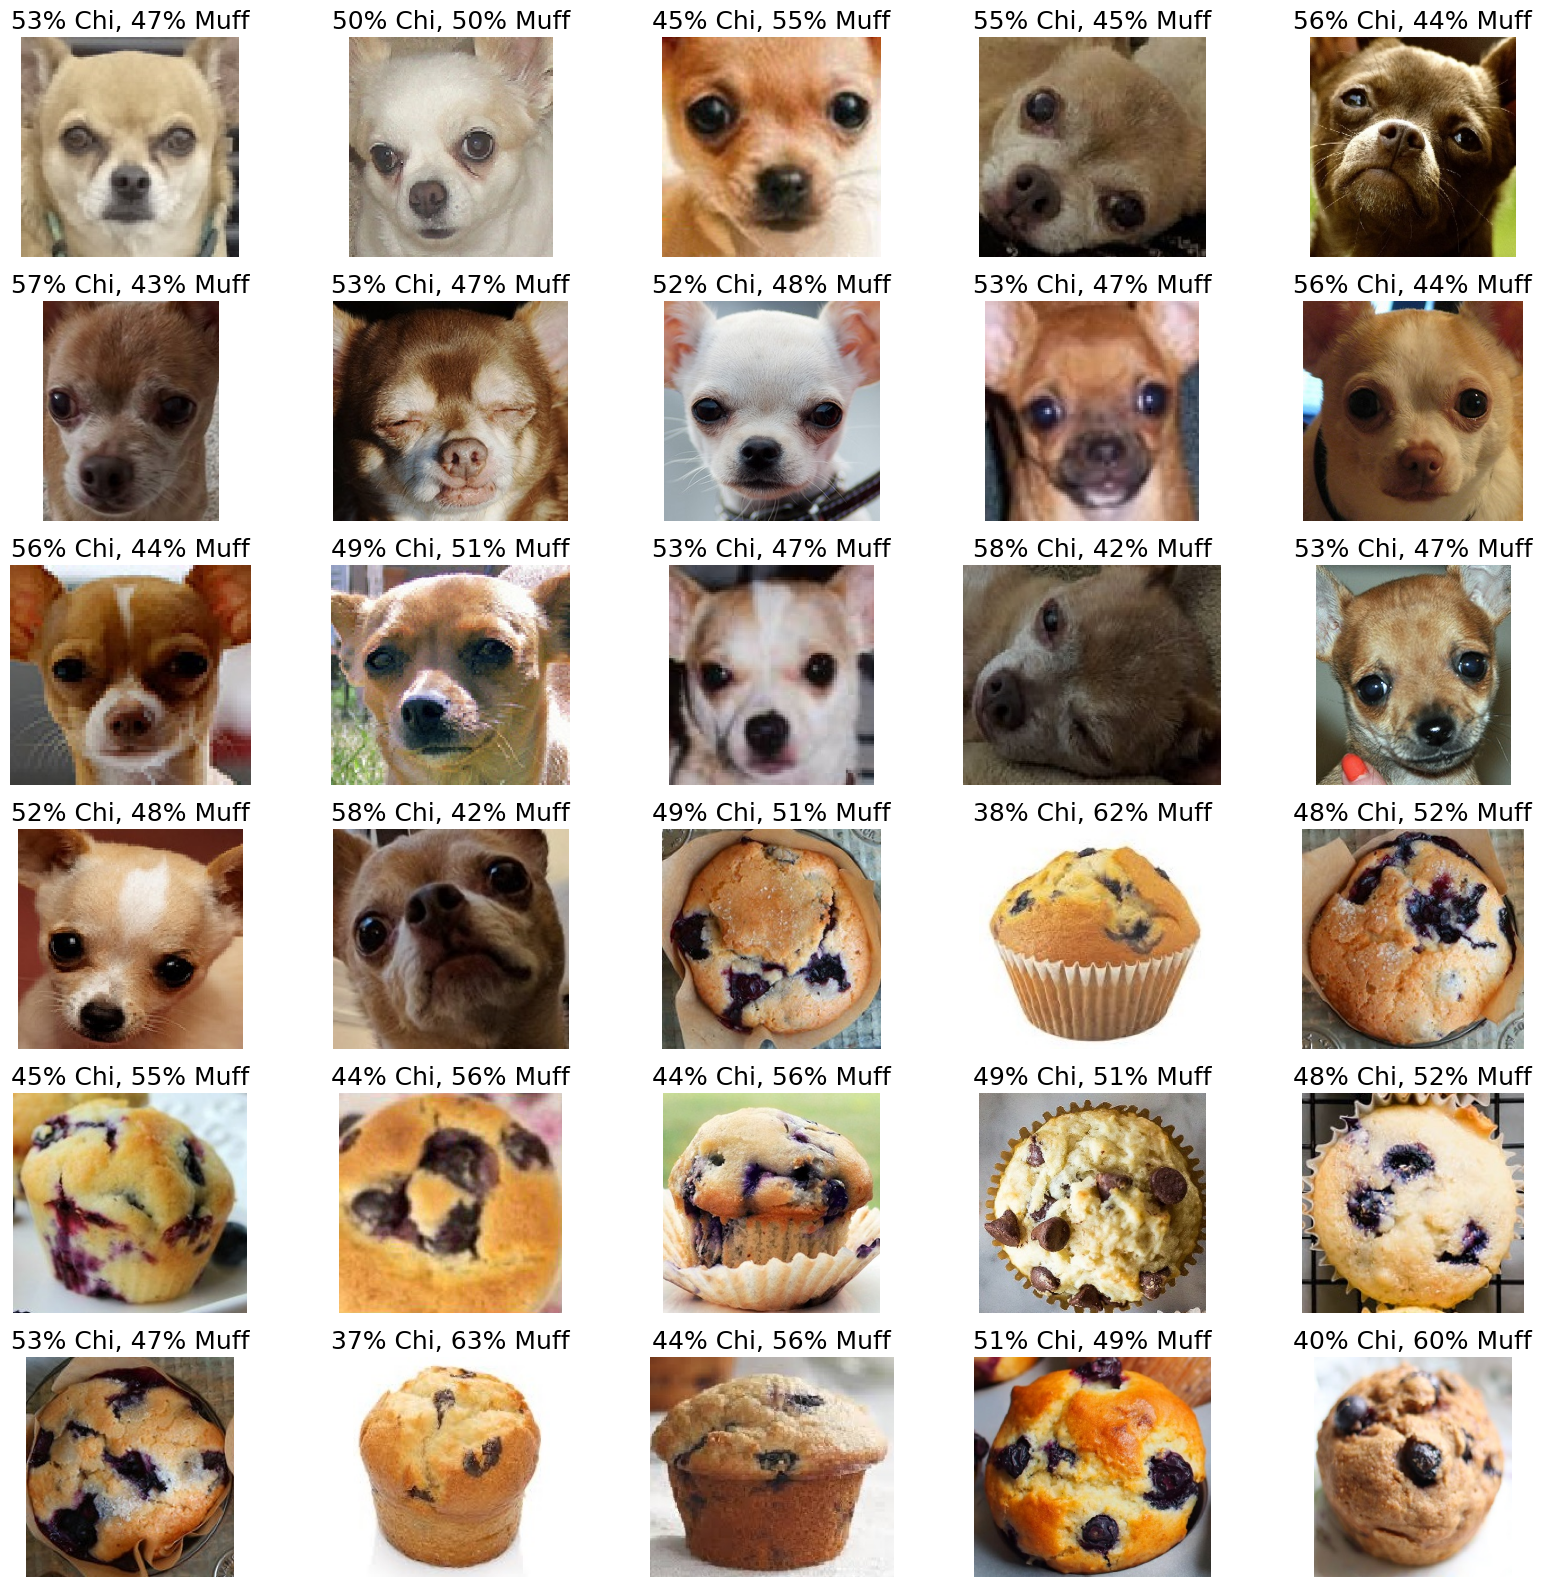

In [18]:
from PIL import Image
from glob import glob
from math import floor

# get all the images from our validation sets
validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
images = [Image.open(img_path) for img_path in validation_img_paths]

# put all the images together to run through our model
validation_batch = torch.stack( [validation_transforms(img).to(device) for img in images])
pred_logits_tensor = model(validation_batch)
pred_probs = pred_logits_tensor.cpu().data.numpy()

# show the probabilities for each picture
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img in enumerate(images):
    ax = axs[floor(i/5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
    ax.imshow(img)

**Consider:** How accurate was your model? How confident were its predictions? Does it make clear-cut decisions?

## Congratulations! You've successfully trained a neural network!

# III.  Can You Do Better?

Now that we've shown you how to train a neural network, can you improve the validation accuracy by tweaking the parameters? **We challenge you to reach 100% accuracy!**

Some parameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
We've modified it significantly to cater to this workshop, and boost the visual appeal.

This tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.